In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [2]:
directory = 'The IQ-OTHNCCD lung cancer dataset'

categories = ['Benign cases', 'Malignant cases', 'Normal cases']

# Image Size Variations

In [3]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_dict = {}
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = imageio.imread(filepath).shape
        if str(height) + ' x ' + str(width) in temp_dict:
            temp_dict[str(height) + ' x ' + str(width)] += 1 
        else:
            temp_dict[str(height) + ' x ' + str(width)] = 1
    
    size_data[i] = temp_dict
        
size_data

{'Benign cases': {'512 x 512': 120},
 'Malignant cases': {'512 x 512': 501,
  '404 x 511': 1,
  '512 x 801': 28,
  '512 x 623': 31},
 'Normal cases': {'512 x 512': 415, '331 x 506': 1}}

Benign cases


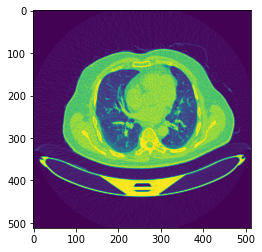

Malignant cases


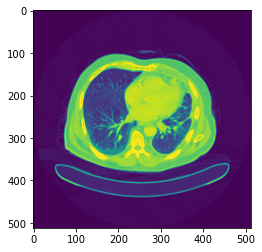

Normal cases


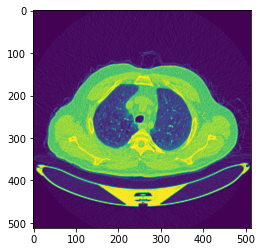

In [4]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

 # Image preprocessing

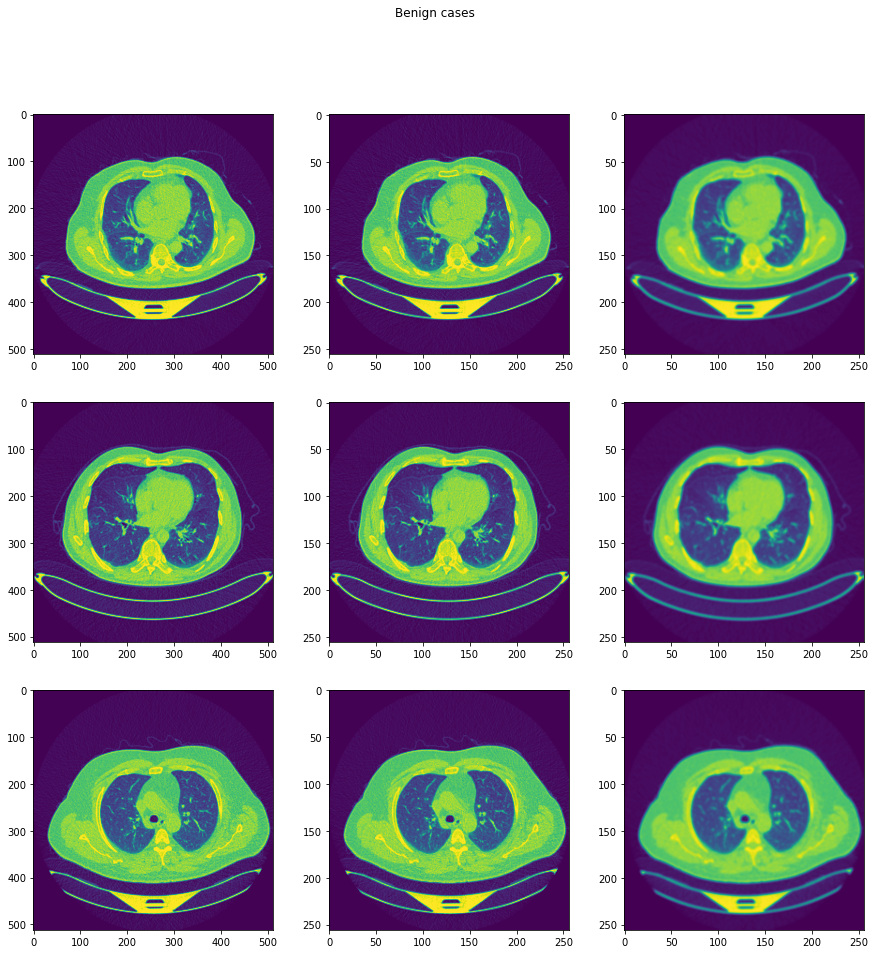

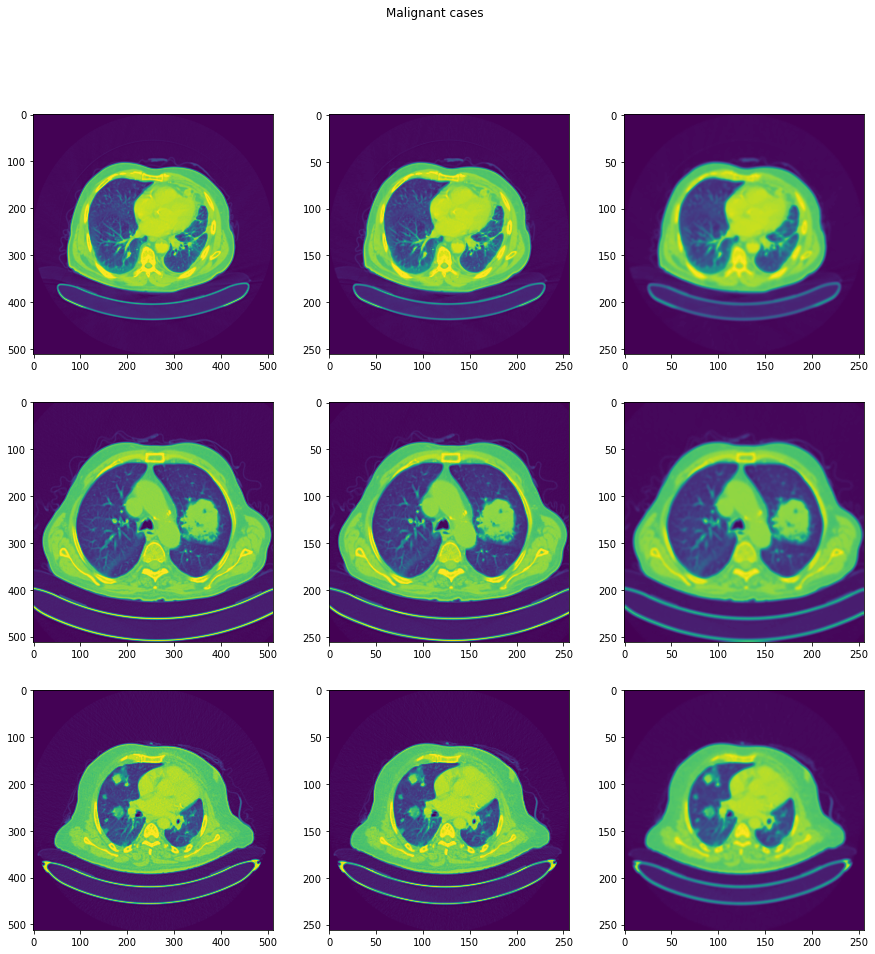

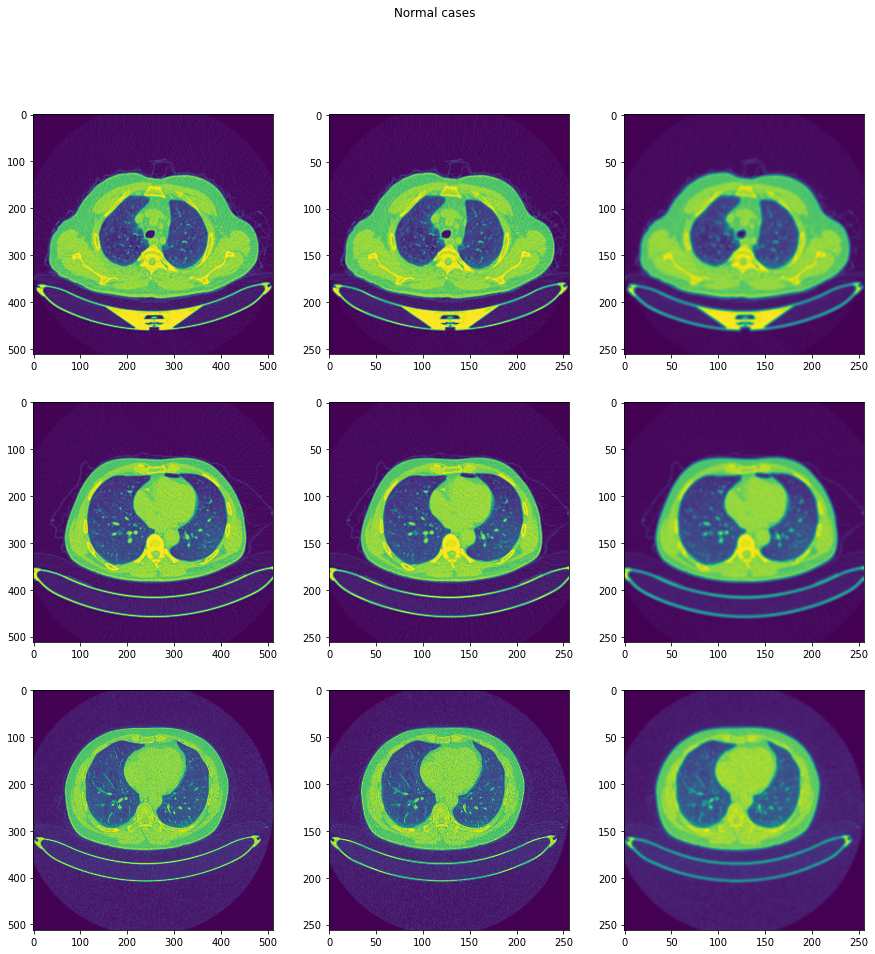

In [5]:
img_size = 256
for i in categories:
    cnt, samples = 0, 3
    fig, ax = plt.subplots(samples, 3, figsize=(15, 15))
    fig.suptitle(i)
    
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for curr_cnt, file in enumerate(os.listdir(path)):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        
        img0 = cv2.resize(img, (img_size, img_size))
        
        img1 = cv2.GaussianBlur(img0, (5, 5), 0)
        
        ax[cnt, 0].imshow(img)
        ax[cnt, 1].imshow(img0)
        ax[cnt, 2].imshow(img1)
        cnt += 1
        if cnt == samples:
            break
        
plt.show()

# Preparing data

In [6]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])
        
random.shuffle(data)

X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)
    
print('X length:', len(X))
print('y counts:', Counter(y))

# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=10, stratify=y)

print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

822 (822, 256, 256, 1)
275 (275, 256, 256, 1)


# Applying SMOTE to oversample the data

In [8]:
print(Counter(y_train), Counter(y_valid))

Counter({1: 420, 2: 312, 0: 90}) Counter({1: 141, 2: 104, 0: 30})


In [9]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

822 (822, 256, 256, 1)
822 (822, 65536)


In [10]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 420, 2: 312, 0: 90})
After SMOTE: Counter({2: 420, 1: 420, 0: 420})


In [11]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

822 (822, 256, 256, 1)
1260 (1260, 256, 256, 1)


# Model Building with SMOTE data

In [12]:
cnn = tf.keras.models.Sequential()

cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(128, activation='relu'))
cnn.add(tf.keras.layers.Dense(64, activation='relu'))
cnn.add(tf.keras.layers.Dense(6, activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 48)      480       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 48)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 48)      20784     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        13856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

In [13]:
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
history = cnn.fit(X_train_sampled, y_train_sampled, batch_size=8, epochs=15, validation_data=(X_valid, y_valid))

Epoch 1/15
158/158 [==============================] - 61s 374ms/step - loss: 0.6575 - accuracy: 0.6921 - val_loss: 0.1771 - val_accuracy: 0.9127
Epoch 2/15
158/158 [==============================] - 57s 360ms/step - loss: 0.0806 - accuracy: 0.9698 - val_loss: 0.0550 - val_accuracy: 0.9818
Epoch 3/15
158/158 [==============================] - 59s 374ms/step - loss: 0.0346 - accuracy: 0.9889 - val_loss: 0.0473 - val_accuracy: 0.9891
Epoch 4/15
158/158 [==============================] - 61s 388ms/step - loss: 0.0260 - accuracy: 0.9960 - val_loss: 0.0297 - val_accuracy: 0.9927
Epoch 5/15
158/158 [==============================] - 59s 376ms/step - loss: 4.9409e-04 - accuracy: 1.0000 - val_loss: 0.1120 - val_accuracy: 0.9927
Epoch 6/15
158/158 [==============================] - 60s 381ms/step - loss: 0.0137 - accuracy: 0.9968 - val_loss: 0.0960 - val_accuracy: 0.9891
Epoch 7/15
158/158 [==============================] - 61s 383ms/step - loss: 3.3653e-04 - accuracy: 1.0000 - val_loss: 0.1275 

In [15]:
y_pred = cnn.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 2s 240ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       1.00      1.00      1.00       141
           2       0.98      1.00      0.99       104

    accuracy                           0.99       275
   macro avg       0.99      0.98      0.99       275
weighted avg       0.99      0.99      0.99       275

[[ 28   0   2]
 [  0 141   0]
 [  0   0 104]]


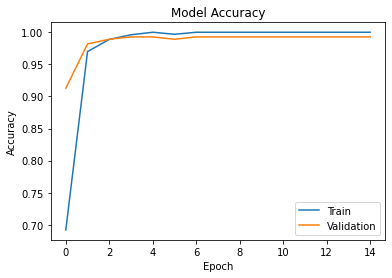

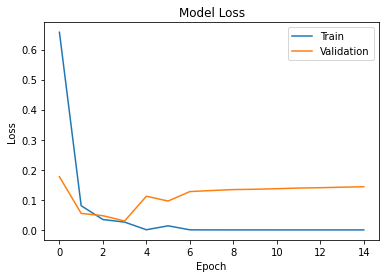

In [16]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Class weighted approach

In [17]:
cnn2 = tf.keras.models.Sequential()

cnn2.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn2.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu'))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn2.add(tf.keras.layers.Flatten())
cnn2.add(tf.keras.layers.Dense(128, activation='relu'))
cnn2.add(tf.keras.layers.Dense(64, activation='relu'))
cnn2.add(tf.keras.layers.Dense(6, activation='softmax'))

cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 48)      480       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 48)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 48)      20784     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 48)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        13856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 32)      

In [18]:
cnn2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
new_weights = {
    0: X_train.shape[0]/(3*Counter(y_train)[0]),
    1: X_train.shape[0]/(3*Counter(y_train)[1]),
    2: X_train.shape[0]/(3*Counter(y_train)[2]),
}

# new_weights[0] = 0.5
# new_weights[1] = 20

new_weights

{0: 3.0444444444444443, 1: 0.6523809523809524, 2: 0.8782051282051282}

In [20]:
history = cnn2.fit(X_train, y_train, batch_size=8, epochs=15, validation_data=(X_valid, y_valid), class_weight=new_weights)

Epoch 1/15
103/103 [==============================] - 38s 354ms/step - loss: 1.1081 - accuracy: 0.4465 - val_loss: 0.9181 - val_accuracy: 0.5891
Epoch 2/15
103/103 [==============================] - 39s 381ms/step - loss: 0.5491 - accuracy: 0.8041 - val_loss: 0.2462 - val_accuracy: 0.9164
Epoch 3/15
103/103 [==============================] - 39s 383ms/step - loss: 0.1654 - accuracy: 0.9453 - val_loss: 0.1625 - val_accuracy: 0.9382
Epoch 4/15
103/103 [==============================] - 38s 373ms/step - loss: 0.0555 - accuracy: 0.9866 - val_loss: 0.0572 - val_accuracy: 0.9782
Epoch 5/15
103/103 [==============================] - 38s 365ms/step - loss: 0.0512 - accuracy: 0.9842 - val_loss: 0.0895 - val_accuracy: 0.9855
Epoch 6/15
103/103 [==============================] - 40s 384ms/step - loss: 0.0364 - accuracy: 0.9915 - val_loss: 0.0230 - val_accuracy: 0.9855
Epoch 7/15
103/103 [==============================] - 38s 370ms/step - loss: 0.0250 - accuracy: 0.9903 - val_loss: 0.0310 - val_ac

# Results

In [21]:
y_pred = cnn2.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 2s 226ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       1.00      1.00      1.00       141
           2       0.98      1.00      0.99       104

    accuracy                           0.99       275
   macro avg       0.99      0.98      0.99       275
weighted avg       0.99      0.99      0.99       275

[[ 28   0   2]
 [  0 141   0]
 [  0   0 104]]


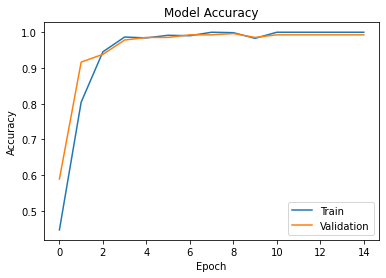

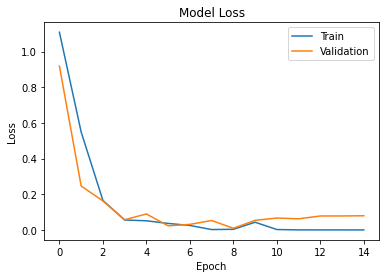

In [22]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Data augmentation

In [23]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True) 
val_datagen = ImageDataGenerator()

In [24]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8) 
val_generator = val_datagen.flow(X_valid, y_valid, batch_size=8)

In [25]:
cnn3 = tf.keras.models.Sequential()

cnn3.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn3.add(tf.keras.layers.Conv2D(filters=48, kernel_size=3, activation='relu'))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn3.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn3.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn3.add(tf.keras.layers.Flatten())
cnn3.add(tf.keras.layers.Dense(128, activation='relu'))
cnn3.add(tf.keras.layers.Dense(64, activation='relu'))
cnn3.add(tf.keras.layers.Dense(6, activation='softmax'))

cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 48)      480       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 48)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 48)      20784     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 48)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        13856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 32)      

In [26]:
cnn3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
history = cnn3.fit(train_generator, epochs=15, validation_data=val_generator, class_weight=new_weights)

Epoch 1/15
103/103 [==============================] - 40s 374ms/step - loss: 1.0645 - accuracy: 0.4684 - val_loss: 0.9660 - val_accuracy: 0.5782
Epoch 2/15
103/103 [==============================] - 37s 359ms/step - loss: 0.8737 - accuracy: 0.6083 - val_loss: 0.6756 - val_accuracy: 0.7236
Epoch 3/15
103/103 [==============================] - 37s 356ms/step - loss: 0.6624 - accuracy: 0.7482 - val_loss: 0.6795 - val_accuracy: 0.7527
Epoch 4/15
103/103 [==============================] - 38s 369ms/step - loss: 0.4824 - accuracy: 0.8345 - val_loss: 0.4822 - val_accuracy: 0.8509
Epoch 5/15
103/103 [==============================] - 38s 370ms/step - loss: 0.3150 - accuracy: 0.8820 - val_loss: 0.2471 - val_accuracy: 0.9055
Epoch 6/15
103/103 [==============================] - 36s 346ms/step - loss: 0.2440 - accuracy: 0.9343 - val_loss: 0.3124 - val_accuracy: 0.8764
Epoch 7/15
103/103 [==============================] - 36s 345ms/step - loss: 0.1606 - accuracy: 0.9513 - val_loss: 0.2134 - val_ac

In [28]:
y_pred = cnn3.predict(X_valid, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_valid, y_pred_bool))

print(confusion_matrix(y_true=y_valid, y_pred=y_pred_bool))

9/9 [==============================] - 2s 225ms/step
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.99      0.99      0.99       141
           2       0.96      1.00      0.98       104

    accuracy                           0.98       275
   macro avg       0.99      0.95      0.97       275
weighted avg       0.98      0.98      0.98       275

[[ 26   1   3]
 [  0 140   1]
 [  0   0 104]]


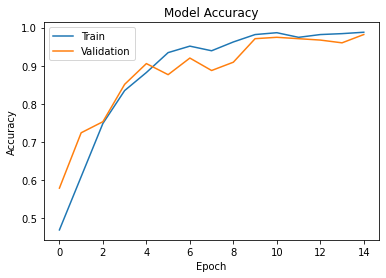

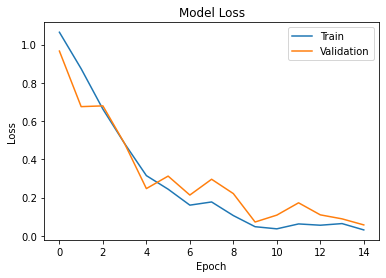

In [29]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()